# Going Deeper CV 2. ResNet Ablation Study

ResNet-34 와 ResNet-50 네트워크를 직접 구현해보자.

![image](https://user-images.githubusercontent.com/84179578/134925860-0f8d7dac-fc18-4f85-b2b9-9446b84e801d.png)

ResNet 34와 50에서 사용된 블록들의 공통점과 차이점과 그 특징은 아래와 같다. 

- ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있다. 
- 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다르다. 
- ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 된다.

## ResNet-34

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어보자.  
ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 `build_resnet()`를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [3]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [4]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

In [5]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

## ResNet-50

In [6]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

## 일반 네트워크(plain network) 만들기

In [7]:
# resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [8]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

In [9]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

In [10]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

---
## 데이터 준비

In [11]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [12]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [13]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [14]:
print(f'Train 이미지 개수 : {len(ds_train)}')
print(f'Test 이미지 개수 : {len(ds_test)}')

Train 이미지 개수 : 18610
Test 이미지 개수 : 4652


모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만든다.

In [15]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [16]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

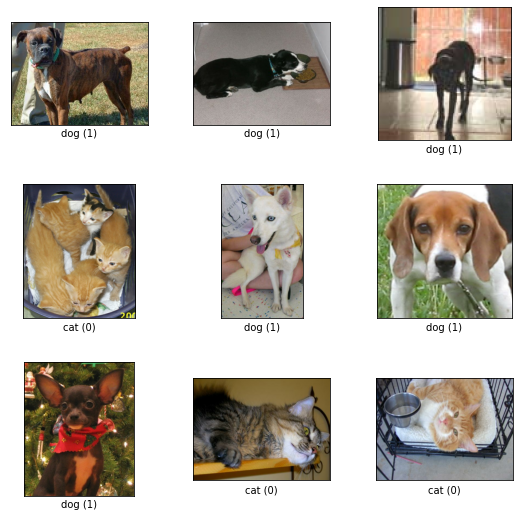

In [17]:
fig = tfds.show_examples(ds_train, ds_info)

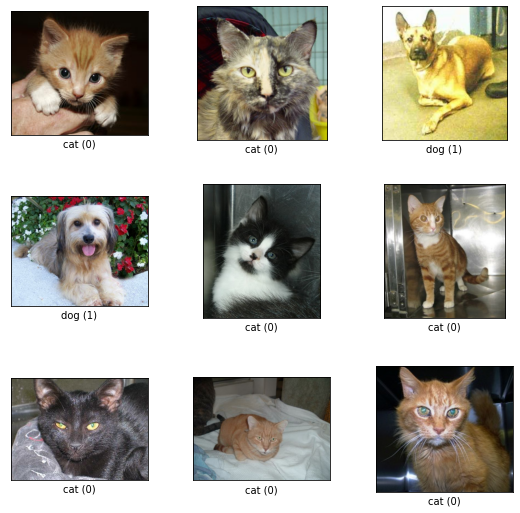

In [18]:
fig = tfds.show_examples(ds_test, ds_info)

----
## 모델 학습

In [19]:
BATCH_SIZE = 64
EPOCH = 20

In [20]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### ResNet-34

In [21]:
model_resnet_34 = build_resnet(input_shape=(224, 224, 3),                                
                               num_classes=1, 
                               is_50=False, 
                               activation='sigmoid', 
                               name='ResNet_34')

In [22]:
model_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = model_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/20
290/290 [==============================] - 283s 818ms/step - loss: 2.5027 - accuracy: 0.5758 - val_loss: 2.1147 - val_accuracy: 0.5177
Epoch 2/20
290/290 [==============================] - 245s 846ms/step - loss: 1.6969 - accuracy: 0.6617 - val_loss: 2.1412 - val_accuracy: 0.5306
Epoch 3/20
290/290 [==============================] - 229s 788ms/step - loss: 1.1829 - accuracy: 0.7414 - val_loss: 1.5569 - val_accuracy: 0.6053
Epoch 4/20
290/290 [==============================] - 229s 791ms/step - loss: 0.8621 - accuracy: 0.7969 - val_loss: 0.9322 - val_accuracy: 0.7129
Epoch 5/20
290/290 [==============================] - 230s 792ms/step - loss: 0.6913 - accuracy: 0.8226 - val_loss: 0.9111 - val_accuracy: 0.6361
Epoch 6/20
290/290 [==============================] - 230s 793ms/step - loss: 0.5644 - accuracy: 0.8585 - val_loss: 0.8847 - val_accuracy: 0.6425
Epoch 7/20
290/290 [==============================] - 229s 791ms/step - loss: 0.4807 - accuracy: 0.8793 - val_loss: 0.7339 -

## ResNet-50

In [23]:
model_resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

In [24]:
model_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = model_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 279s 751ms/step - loss: 5.8720 - accuracy: 0.5992 - val_loss: 4.5290 - val_accuracy: 0.6418
Epoch 2/20
290/290 [==============================] - 159s 550ms/step - loss: 4.0164 - accuracy: 0.7219 - val_loss: 3.6356 - val_accuracy: 0.6703
Epoch 3/20
290/290 [==============================] - 160s 551ms/step - loss: 2.8206 - accuracy: 0.7644 - val_loss: 2.4603 - val_accuracy: 0.6959
Epoch 4/20
290/290 [==============================] - 160s 551ms/step - loss: 2.1071 - accuracy: 0.7975 - val_loss: 2.0192 - val_accuracy: 0.7369
Epoch 5/20
290/290 [==============================] - 160s 551ms/step - loss: 1.6298 - accuracy: 0.8410 - val_loss: 2.2133 - val_accuracy: 0.5345
Epoch 6/20
290/290 [==============================] - 160s 552ms/step - loss: 1.3232 - accuracy: 0.8743 - val_loss: 1.9971 - val_accuracy: 0.6269
Epoch 7/20
290/290 [==============================] - 160s 551ms/step - loss: 1.1381 - accuracy: 0.8863 - val_loss: 1.2029 -

### Plain-34

In [25]:
model_plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

In [26]:
model_plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = model_plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 238s 764ms/step - loss: 2.0726 - accuracy: 0.5720 - val_loss: 1.6047 - val_accuracy: 0.5013
Epoch 2/20
290/290 [==============================] - 221s 762ms/step - loss: 1.3388 - accuracy: 0.6371 - val_loss: 4.0542 - val_accuracy: 0.5360
Epoch 3/20
290/290 [==============================] - 221s 762ms/step - loss: 1.0335 - accuracy: 0.7069 - val_loss: 1.0028 - val_accuracy: 0.6471
Epoch 4/20
290/290 [==============================] - 221s 763ms/step - loss: 0.8487 - accuracy: 0.7546 - val_loss: 0.9868 - val_accuracy: 0.4505
Epoch 5/20
290/290 [==============================] - 221s 763ms/step - loss: 0.7138 - accuracy: 0.7949 - val_loss: 0.9256 - val_accuracy: 0.6159
Epoch 6/20
290/290 [==============================] - 221s 762ms/step - loss: 0.6396 - accuracy: 0.8218 - val_loss: 0.8680 - val_accuracy: 0.7031
Epoch 7/20
290/290 [==============================] - 221s 763ms/step - loss: 0.5908 - accuracy: 0.8305 - val_loss: 0.6894 -

### Plain-50

In [27]:
model_plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

In [28]:
model_plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = model_plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 422s 1s/step - loss: 4.6536 - accuracy: 0.5174 - val_loss: 3.0509 - val_accuracy: 0.4824
Epoch 2/20
290/290 [==============================] - 369s 1s/step - loss: 2.7958 - accuracy: 0.5533 - val_loss: 2.3303 - val_accuracy: 0.4906
Epoch 3/20
290/290 [==============================] - 360s 1s/step - loss: 2.1257 - accuracy: 0.5677 - val_loss: 1.8715 - val_accuracy: 0.5323
Epoch 4/20
290/290 [==============================] - 361s 1s/step - loss: 1.7683 - accuracy: 0.5994 - val_loss: 1.7315 - val_accuracy: 0.5152
Epoch 5/20
290/290 [==============================] - 361s 1s/step - loss: 1.5636 - accuracy: 0.6103 - val_loss: 1.5029 - val_accuracy: 0.5220
Epoch 6/20
290/290 [==============================] - 361s 1s/step - loss: 1.4342 - accuracy: 0.6245 - val_loss: 1.9077 - val_accuracy: 0.5569
Epoch 7/20
290/290 [==============================] - 361s 1s/step - loss: 1.3136 - accuracy: 0.6672 - val_loss: 1.3804 - val_accuracy: 0.5094

## 학습과정 시각화 및 결과 비교

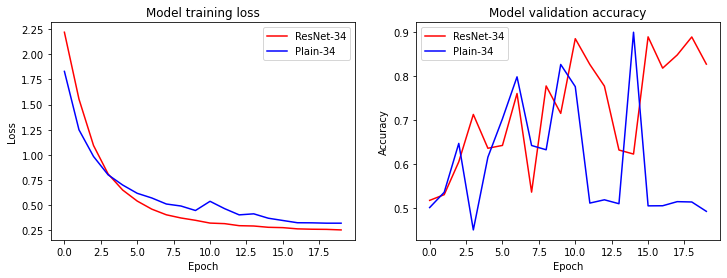

In [38]:
# ResNet-34 vs Plain-34
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

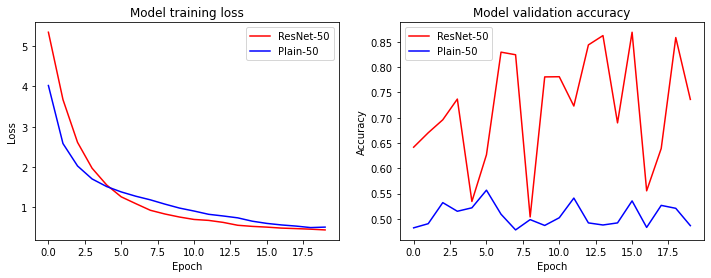

In [39]:
# ResNet-50 vs Plain-50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

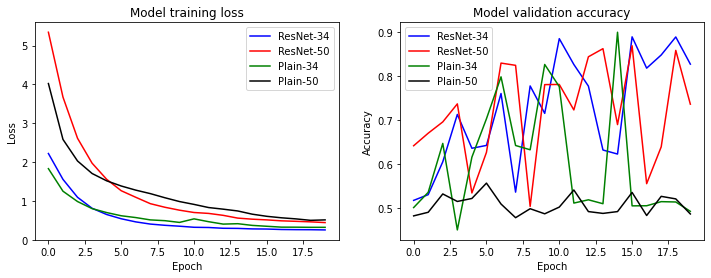

In [40]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'g')
plt.plot(history_plain_50.history['loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

학습시간이 오래걸려 작은 Epoch 로 실험한 결과 accuracy 그래프가 불안정하지만, 전체적으로 ResNet 의 성능이 더 좋은 것을 확인 할 수 있다.

|모델|validation set accuracy|
|:----:|:----:|
|__ResNet-34__|__0.827__|
|__ResNet-50__|__0.736__|
|Plain-34|0.4927|
|Plain-50|0.4868|

결과적으로, ResNet의 Residual Block 을 없애본 결과 성능이 떨어지는 것을 확인하였고, Residual block 의 성능 향상 효과를 직접 확인 할 수 있다.